<a target="_blank" href="https://colab.research.google.com/github/ZHAW-ZAV/TSO-FS25-students/blob/main/03_forecasting/03_01_forecasting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

import sys
import os

IN_COLAB = "google.colab" in sys.modules

file_id_GOOG = "1wfGsm4fDJx3iM930kWbHgDR-W2kdkEw5"

if IN_COLAB:
    path_to_GOOG = "/content/data/GOOG_Closing.csv"
    os.makedirs(os.path.dirname(path_to_GOOG), exist_ok=True)
    !gdown "https://drive.google.com/uc?id={file_id_GOOG}" -O "{path_to_GOOG}"
else:
    import gdown

    url = f"https://drive.google.com/uc?id={file_id_GOOG}"
    path_to_GOOG = "data/GOOG_Closing.csv"
    os.makedirs(os.path.dirname(path_to_GOOG), exist_ok=True)
    gdown.download(url, path_to_GOOG, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1wfGsm4fDJx3iM930kWbHgDR-W2kdkEw5
To: /Users/wate/Documents/GitHub/TSO-FS25/03_forecasting/data/GOOG_Closing.csv
100%|██████████| 3.20k/3.20k [00:00<00:00, 7.08MB/s]


The code above loads the data, do not modify.

***

# TSO Semester Week 3: Forecasting

In this exercise, we will focus on all topics mentioned in the **TSO forecasting script**, Sections *"Introduction to Time Series"* to and including *"Exponential Smoothing"*. Consequently, this exercise focuses on working with time series data, handling missing values, and applying forecasting models.

This exercise consists of the following eight parts:
1. Importing and Exploring Time Series Data
2. Time Series Visualization
3. Handling Missing Data in Time Series
4. Decomposition
5. Applying Basic Forecasting Methods
6. Simple Exponential Smoothing (for time series without trend and seasonality)
7. Exponential Smoothing with Additive Trend
8. Exponential Smoothing with Additive Trend and Seasonality


***
## PART 1: Importing and Exploring Time Series Data


### Tasks:
1. Import the *Google closing price* data set, which is provided in file *GOOG_Closing.csv*. This time series contains the daily closing price of the Google stock from August 2024 to December 2024.
2. Import the *air passenger* data set, which you can download from the *statsmodels* library using the code snippet provided below.
3. Display the first few rows of each data set to verify the import.

### Import Google Data Set

In [2]:
df_GOOG = pd.read_csv(path_to_GOOG, parse_dates=["Date"], index_col="Date")
df_GOOG.head()

Close
Date                   
2024-08-01  1194.640769
2024-08-02  1043.498593
2024-08-05  1721.946513
2024-08-06  1193.523773
2024-08-07  1077.734319

### Air Passenger Data Set (from Statsmodels)
Import the Air Passenger Data Set, which is provided by the **statsmodels** library.

In [3]:
# Load the AirPassengers dataset
data = sm.datasets.get_rdataset('AirPassengers', 'datasets')
df_PAX = data.data

# Convert 'time' to datetime and set as index
df_PAX['Month'] = pd.date_range(start='1949-01', periods=len(df_PAX), freq='ME')
df_PAX.set_index('Month', inplace=True)
df_PAX.head()

time  value
Month                         
1949-01-31  1949.000000    112
1949-02-28  1949.083333    118
1949-03-31  1949.166667    132
1949-04-30  1949.250000    129
1949-05-31  1949.333333    121

***
## PART 2: Time Series Visualization
This part refers to Section *Introduction to Time Series* in the TSO forecasting script.

### Tasks:
1. Plot the *Google closing price* time series.
2. Plot the *air passenger* data set.
3. Add appropriate labels and grid lines to enhance readability of your plots.

In [4]:
fig = px.line(df_PAX, x=df_PAX.index, y="value", markers=True, title="Passenger Observations")

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Number of Passengers",
    font=dict(size=16),
    showlegend=True
)

fig.show()

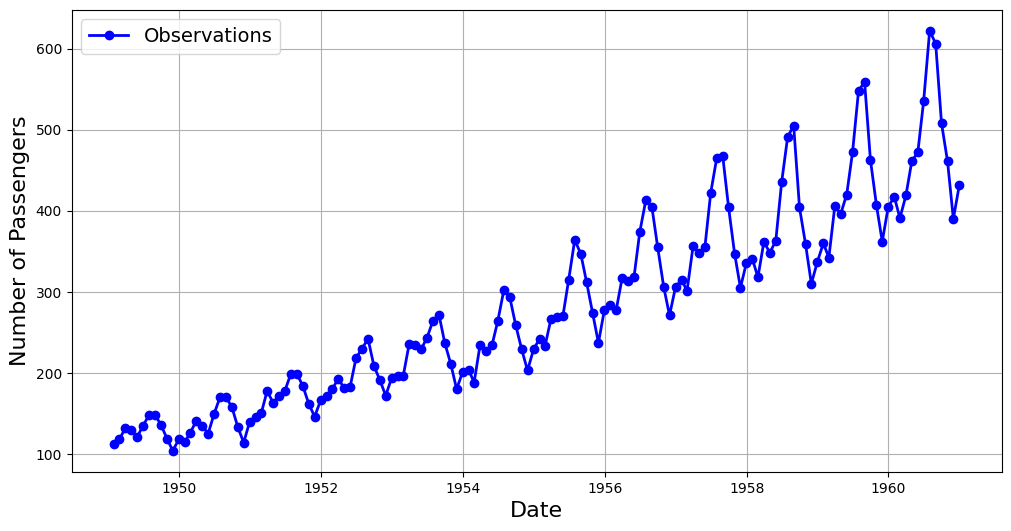

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_PAX["value"], label="Observations", marker="o", color='b', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passengers", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

*** 
## PART 3: Handling Missing Data
This part refers to Section *Introduction to Time Series* in the TSO forecasting script.

### Tasks:
1. Check for missing values in the *Google closing price* data set.
2. Apply an appropriate method to handle / fill the missing values.
3. Plot the 'modified', i.e., interpolated, time series alongside the original one.


In [6]:
# Ensure interpolation is done before plotting
df_GOOG["Interpolated_Close"] = df_GOOG["Close"].interpolate(method='linear')

# Create figure
fig = px.line(df_GOOG, x=df_GOOG.index, y=["Interpolated_Close", "Close"], 
              markers=True, title="GOOG Closing Price with Linear Interpolation")

# Update traces for colors and labels
fig.data[0].line.color = "red"  # Interpolated line in red
fig.data[0].name = "Linear Interpolation"

fig.data[1].line.color = "blue"  # Original observations in blue
fig.data[1].name = "Observations"

# Layout settings
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Closing Price of GOOG [USD]",
    font=dict(size=16),
    showlegend=True
)

fig.show()

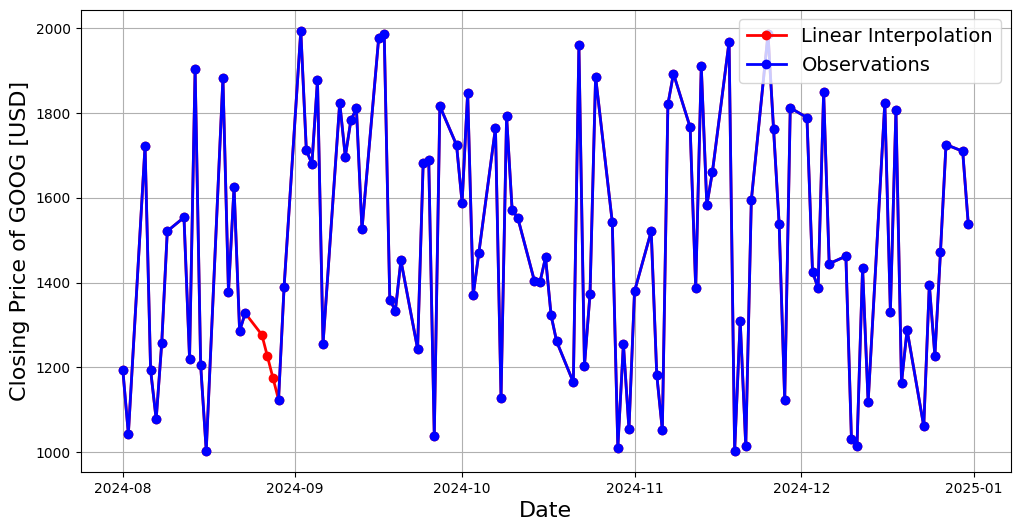

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df_GOOG.index, df_GOOG.Close.interpolate(method='linear'), 'r', marker='o', linewidth=2, label='Linear Interpolation')
plt.plot(df_GOOG['Close'], label="Observations", marker="o", color='b', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Closing Price of GOOG [USD]", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

*** 
## PART 4: Decomposition
This part refers to Section *Patterns in Time Series* in the TSO forecasting script.

### Tasks:
1. Decompose the air passengers data set in trend, seasonal component, and residual (i.e., cyclical & random component)


In [11]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_PAX.value, model='multiplicative', period=12)

# Create a 4-row subplot figure
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                    subplot_titles=["Observed", "Trend", "Seasonal", "Residual"])

# Add traces for each component
fig.add_trace(go.Scatter(x=decompose.observed.index, y=decompose.observed, 
                         mode='lines', line=dict(color='black', width=2), name="Observed"), row=1, col=1)

fig.add_trace(go.Scatter(x=decompose.trend.index, y=decompose.trend, 
                         mode='lines', line=dict(color='blue', width=2), name="Trend"), row=2, col=1)

fig.add_trace(go.Scatter(x=decompose.seasonal.index, y=decompose.seasonal, 
                         mode='lines', line=dict(color='green', width=2), name="Seasonal"), row=3, col=1)

fig.add_trace(go.Scatter(x=decompose.resid.index, y=decompose.resid, 
                         mode='lines', line=dict(color='cyan', width=2), name="Residual"), row=4, col=1)

# Update layout
fig.update_layout(
    height=800, width=1000,
    showlegend=False,
    title_text="Time Series Decomposition",
    xaxis4_title="Date"
)

# Enable grid lines
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

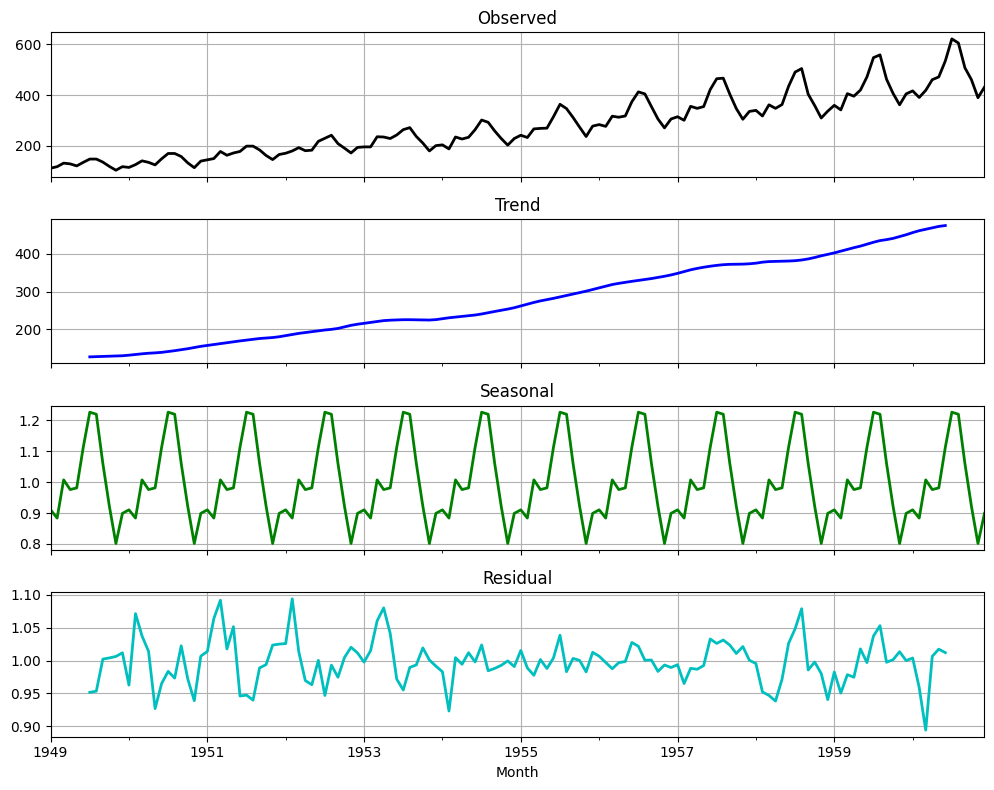

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_PAX.value, model='multiplicative', period=12)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

decompose.observed.plot(ax=ax1, title='Observed', color='k', linewidth=2)
ax1.grid(True)
decompose.trend.plot(ax=ax2, title='Trend', color='b', linewidth=2)
ax2.grid(True)
decompose.seasonal.plot(ax=ax3, title='Seasonal', color='g', linewidth=2)
ax3.grid(True)
decompose.resid.plot(ax=ax4, title='Residual', color='c', linewidth=2)
ax4.grid(True)

plt.tight_layout()

***
## PART 5: Applying Basic Forecasting Methods
This part refers to Section *Simple Forecasting Methods* in the TSO forecasting script.

### Tasks:
1. Apply the **naive forecasting** method to either the *Google closing price* or the *air passenger* data set (decide which data set is more appropriate for the usage of the na\"ive method). Plot your results (i.e., the observations and your forecast).
2. Apply the **average forecasting method** to either the *Google closing price* or the *air passenger* data set (decide which data set is more appropriate for the usage of the na\"ive method). Plot your results (i.e., the observations and your forecast).
3. Apply the **drift forecasting method** to either the *Google closing price* or the *air passenger* data set (decide which data set is more appropriate for the usage of the na\"ive method). Plot your results (i.e., the observations and your forecast).

### Naive Method

In [13]:
forecast_horizon = 12

# Create a list of the last observation repeated for the forecast horizon
forecast_naive = [df_GOOG["Interpolated_Close"].iloc[-1]] * forecast_horizon

# Create a forecast index (ensuring daily frequency)
forecast_index = pd.date_range(start=df_GOOG.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_horizon, 
                               freq='D')

# Convert to a Series
forecast_naive = pd.Series(forecast_naive, index=forecast_index, name="Naive Forecast")

# Combine the original data with the forecast
df_combined = pd.concat([df_GOOG["Interpolated_Close"], forecast_naive])

# Plot the combined data
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_GOOG.index, y=df_GOOG["Interpolated_Close"],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_naive.index, y=forecast_naive,
                         mode="lines+markers", name="Naive Forecast", line=dict(color='red', dash="dash")))

# Update layout
fig.update_layout(
    title="GOOG Closing Price with Naive Forecast",
    xaxis_title="Date",
    yaxis_title="Closing Price of GOOG [USD]",
    font=dict(size=16),
    showlegend=True
)

fig.show()


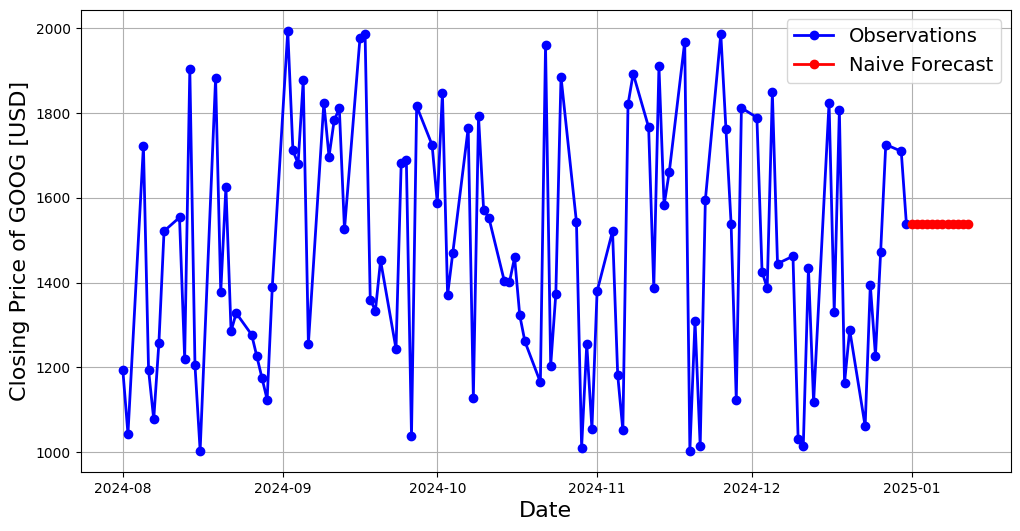

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df_GOOG["Interpolated_Close"], label="Observations", marker="o", color='b', linewidth=2)
plt.plot(forecast_naive, label="Naive Forecast", marker="o", color='r', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Closing Price of GOOG [USD]", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

### Average Method

In [15]:
forecast_horizon = 12

# Create a list of the last observation repeated for the forecast horizon
forecast_mean = [df_GOOG['Close'].mean()] * forecast_horizon

# Create a forecast index
forecast_index = pd.date_range(start=df_GOOG.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_horizon, 
                               freq='D')  # Ensure daily frequency

forecast_mean = pd.Series(forecast_mean, index=forecast_index)

# Combine the original data with the forecast
df_combined = pd.concat([df_GOOG["Interpolated_Close"], forecast_mean])

# Plot the combined data
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_GOOG.index, y=df_GOOG["Interpolated_Close"],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_mean.index, y=forecast_mean,
                         mode="lines+markers", name="Mean Forecast", line=dict(color='red', dash="dash")))

# Update layout
fig.update_layout(
    title="GOOG Closing Price with Naive Forecast",
    xaxis_title="Date",
    yaxis_title="Closing Price of GOOG [USD]",
    font=dict(size=16),
    showlegend=True
)

fig.show()

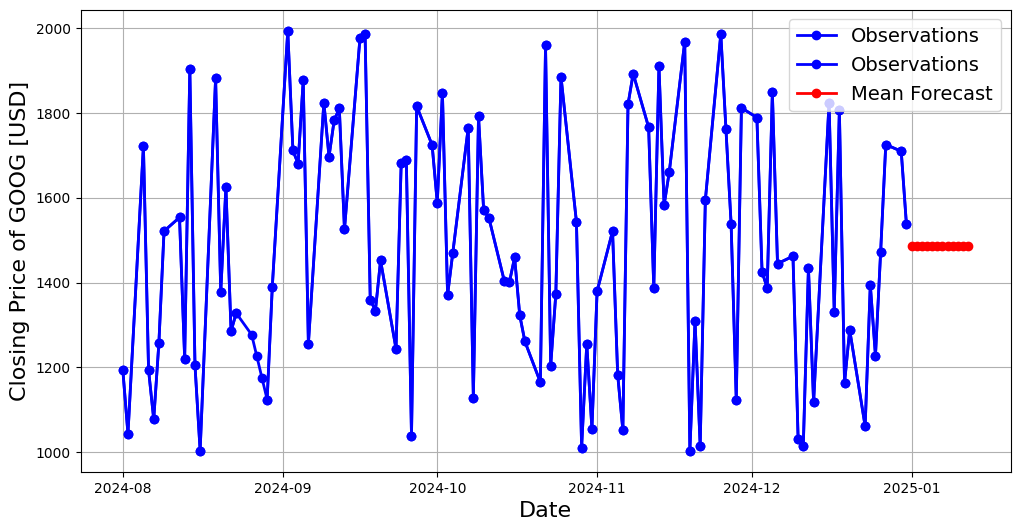

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_GOOG, label="Observations", marker="o", color='b', linewidth=2)
plt.plot(forecast_mean, label="Mean Forecast", marker="o", color='r', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Closing Price of GOOG [USD]", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

### Drift Method

In [19]:
forecast_horizon = 12

# Compute drift
y_T = df_PAX.value.iloc[-1]  # Last observed value
y_1 = df_PAX.value.iloc[0]   # First observed value
T = len(df_PAX.value)        # Number of observations

drift = y_T + (y_T - y_1) / (T - 1) * np.arange(1, forecast_horizon + 1)

forecast_index = pd.date_range(start=df_PAX.index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_horizon, 
                               freq='ME')

# Create a forecast series
drift_forecast = pd.Series(drift, index=forecast_index)


# Combine the original data with the forecast
df_combined = pd.concat([df_PAX, drift_forecast])

# Plot the combined data
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_PAX.index, y=df_PAX["value"],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=drift_forecast.index, y=drift_forecast,
                         mode="lines+markers", name="Drift Forecast", line=dict(color='red', dash="dash")))

# Update layout
fig.update_layout(
    title="Drift Method for AirPassengers Dataset",
    xaxis_title="Date",
    yaxis_title="Number of Passengers",
    font=dict(size=16),
    showlegend=True
)

fig.show()

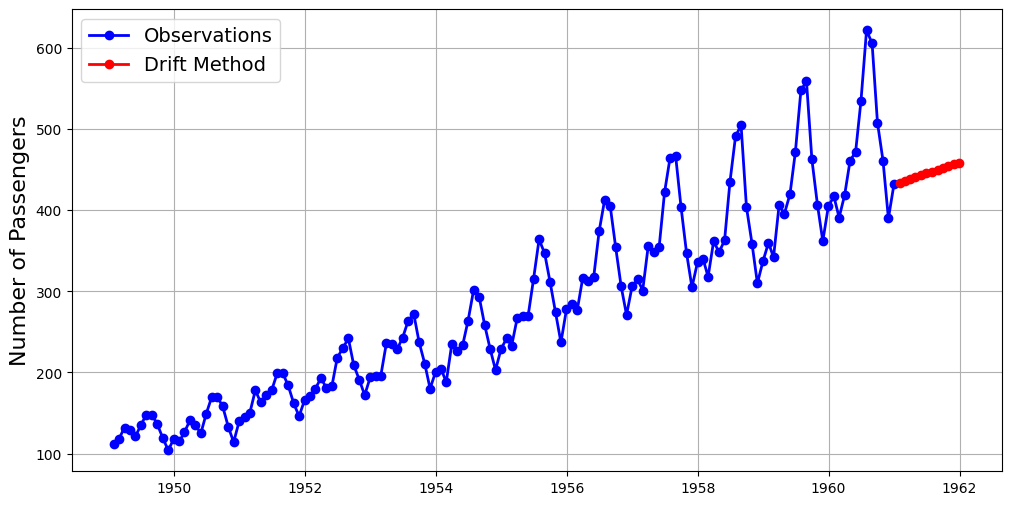

In [20]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_PAX['value'], label="Observations", marker="o", color='b', linewidth=2)
plt.plot(drift_forecast, label="Drift Method", marker="o", linestyle="-", color='r', linewidth=2)
plt.ylabel("Number of Passengers", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

***
## PART 6: Simple Exponential Smoothing (for time series without trend and seasonality)
This part refers to Section *Exponential Smoothing* in the TSO forecasting script.

### Tasks:
1. Fit a simple exponential smoothing model (i.e., no trend, no seasonality) to the **daily** *Google stock closing price* **changes**.
2. Forecast the next 12 days using the fitted model.
3. Plot the observed data, fitted values, and forecast.


In [21]:
df_GOOG['close_change']=df_GOOG['Interpolated_Close'].diff()

# Create interactive plot
fig = px.line(df_GOOG, x=df_GOOG.index, y="close_change", markers=True, 
              title="Daily Change in Closing Price of GOOG")

# Update layout
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Daily Change in Closing Price of GOOG [USD]",
    font=dict(size=16),
    showlegend=True
)

fig.show()

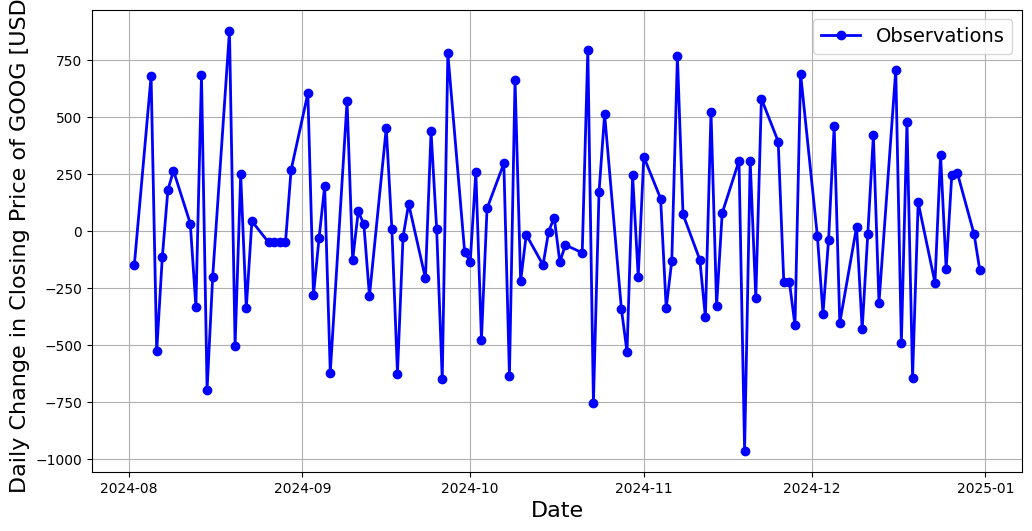

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_GOOG['close_change'], label="Observations", marker="o", color='b', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Daily Change in Closing Price of GOOG [USD]", fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [23]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

alpha = 0.3
model = SimpleExpSmoothing(df_GOOG['close_change'].dropna(), initialization_method="heuristic")
fitted_model = model.fit(smoothing_level=alpha, optimized=False)


# Forecast the next 12 days
forecast_horizon = 12
forecast = fitted_model.forecast(forecast_horizon)

# Create a forecast index
forecast_index = pd.date_range(start=df_GOOG.index[-1] + pd.Timedelta(days=1), 
                               periods=forecast_horizon, 
                               freq='B')  # Ensure daily frequency

# Convert forecast to a Pandas Series
forecast_series = pd.Series(forecast, index=forecast_index)

# Combine the original data with the forecast
df_combined = pd.concat([df_GOOG["close_change"], forecast_series])

fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_GOOG.index, y=df_GOOG["close_change"],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series,
                         mode="lines+markers", name="Forecast", line=dict(color='red')))

# Use MathJax formatting for the title
fig.update_layout(
    title=r"Exponential Smoothing, $\alpha = {:.2f}$".format(alpha),  # Ensure correct LaTeX formatting
    xaxis_title="Date",
    yaxis_title="Daily Change in Closing Price of GOOG [USD]",
    font=dict(size=16),
    showlegend=True
)

fig.show()

/Users/wate/Documents/GitHub/TSO-FS25/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



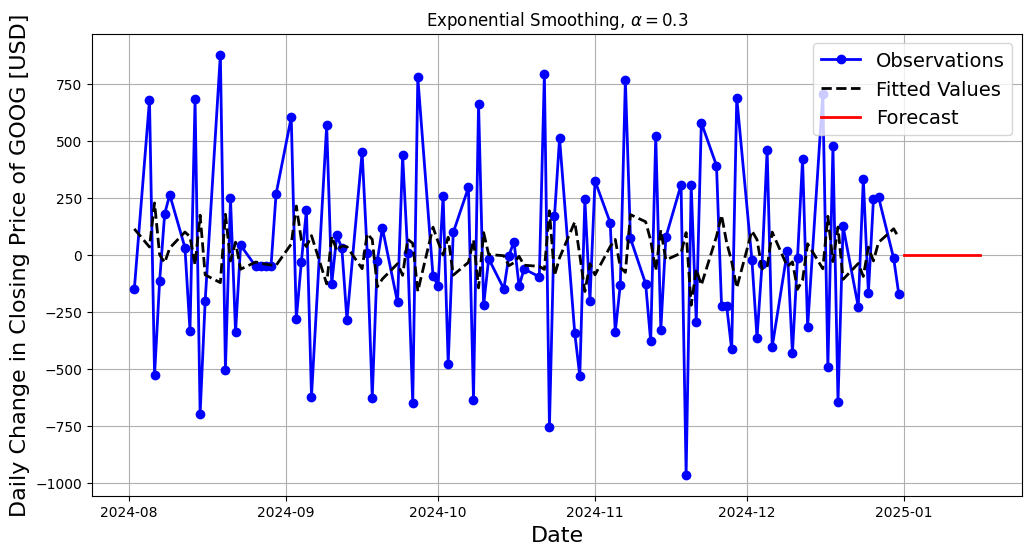

In [25]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_GOOG['close_change'], label="Observations", marker="o", color='b', linewidth=2)
plt.plot(fitted_model.fittedvalues, label="Fitted Values", linestyle="--",color='k', linewidth=2)
plt.plot(forecast_series, label="Forecast", linestyle="-", color='r', linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Daily Change in Closing Price of GOOG [USD]", fontsize=16)
plt.title(f'Exponential Smoothing, $\\alpha={alpha}$')
plt.grid()
plt.legend(fontsize=14)

***
## PART 7: Exponential Smoothing with Additive Trend
This part refers to Section *Exponential Smoothing* in the TSO forecasting script.

### Tasks:
1. Fit an exponential smoothing model with an additive trend to the *air passenger* data set.
2. Forecast the next 24 month using the fitted model.
3. Plot the observed data, fitted values, and forecast.

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

alpha = 0.7
beta = 0.005

df_PAX.index = pd.to_datetime(df_PAX.index)
df_PAX = df_PAX.asfreq("ME")  # Adjust frequency if needed


# Fit the model with additive trend and multiplicative seasonality
model = ExponentialSmoothing(
    df_PAX['value'],
    trend="add",
    seasonal=None,
    initialization_method="known",  # Use known initialization
    initial_level=df_PAX['value'].iloc[0],  # Provide initial level directly
    initial_trend=0                    # Provide initial trend directly
)

# Fit the model with specified smoothing parameters
fitted_model = model.fit(
      smoothing_level=alpha,    # Alpha: Level smoothing
      smoothing_trend=beta,     # Beta: Trend smoothing (Replaces smoothing_slope)
      optimized=False           # Set to False since we specify parameters
)

# Forecast for the next 2 years (24 months)
forecast_horizon = 24
forecast = fitted_model.forecast(forecast_horizon)

# Create a forecast index
forecast_index = pd.date_range(start=df_PAX['value'].index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_horizon, 
                               freq='ME')

# Convert the forecast to a Pandas Series
forecast_series = pd.Series(forecast, index=forecast_index)


# Combine the original data with the forecast
df_combined = pd.concat([df_PAX['value'], forecast_series])

# Plot the combined data
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_PAX.index, y=df_PAX['value'],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series,
                         mode="lines+markers", name="Forecast", line=dict(color='red')))

# Update layout
fig.update_layout(
    title=f'Exponential Smoothing on AirPassengers Dataset, $\\alpha={alpha}, \\beta={beta}$',
    xaxis_title="Year",
    yaxis_title="Number of Passengers",
    font=dict(size=16),
    showlegend=True
)

fig.show()

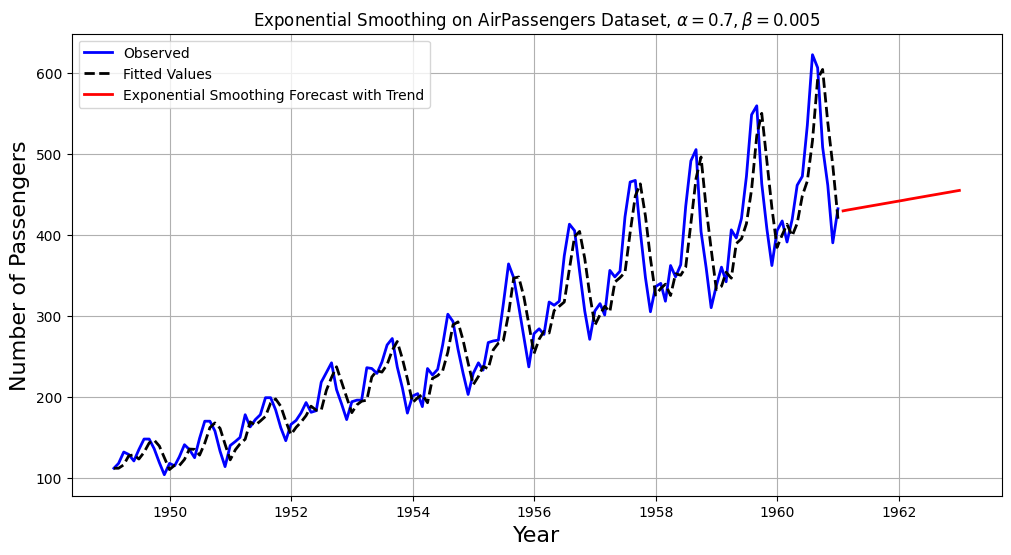

In [27]:
# Plot the observed data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_PAX['value'], label="Observed", color='b', linewidth=2)
plt.plot(fitted_model.fittedvalues, label="Fitted Values", linestyle="--", color='k', linewidth=2)
plt.plot(forecast_series, label="Exponential Smoothing Forecast with Trend", linestyle="-", color='r', linewidth=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of Passengers",fontsize=16)
plt.title(f'Exponential Smoothing on AirPassengers Dataset, $\\alpha={alpha}, \\beta={beta}$')
plt.legend()
plt.grid()
plt.show()

***
## PART 8: Exponential Smoothing with Additive Trend and Seasonality
This part refers to Section *Exponential Smoothing* in the TSO forecasting script.

### Tasks:
1. Fit an exponential smoothing model with an additive trend and seasonality to the *air passenger* data set.
2. Forecast the next 24 month using the fitted model.
3. Plot the observed data, fitted values, and forecast.

In [46]:
alpha = 0.31
beta = 1.37e-09
gamma = 0.60


# Apply Holt-Winters' Exponential Smoothing
model = ExponentialSmoothing(
    df_PAX['value'],
    trend="add",             # Additive trend
    seasonal="mul",          # Multiplicative seasonality
    seasonal_periods=12,     # Monthly data with yearly seasonality
    initialization_method="estimated"  # Let the model estimate initial values
)

# Fit the model
fitted_model = model.fit(
    smoothing_level=alpha,      # Alpha: Level smoothing
    smoothing_trend=beta,       # Beta: Trend smoothing
    smoothing_seasonal=gamma,   # Gamma: Seasonal smoothing
    optimized=False             # Set to False since we specify parameters
)

# Forecast for the next 2 years (24 months)
forecast_horizon = 24
forecast = fitted_model.forecast(forecast_horizon)

# Create a forecast index
forecast_index = pd.date_range(start=df_PAX['value'].index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_horizon, 
                               freq='ME')

# Convert the forecast to a Pandas Series
forecast_series = pd.Series(forecast, index=forecast_index)


# Combine the original data with the forecast
df_combined = pd.concat([df_PAX['value'], forecast_series])

# Plot the combined data
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=df_PAX.index, y=df_PAX['value'],
                         mode="lines+markers", name="Observations", line=dict(color='blue')))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series,
                         mode="lines+markers", name="Forecast", line=dict(color='red')))

# Update layout
fig.update_layout(
    title=f'Exponential Smoothing on AirPassengers Dataset, $\\alpha={alpha}, \\beta={beta}$',
    xaxis_title="Year",
    yaxis_title="Number of Passengers",
    font=dict(size=16),
    showlegend=True
)

fig.show()

In [ ]:
# Plot the observed data, fitted values, and forecast
plt.figure(figsize=(12, 6))
plt.plot(df_PAX['value'], label="Observed", color='b', linewidth=2)
plt.plot(fitted_model.fittedvalues, label="Fitted Values", linestyle="--", color='k', linewidth=2)
plt.plot(forecast_series, label="Forecast", linestyle="-", color='r', linewidth=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of Passengers", fontsize=16)
plt.title(f'Exponential Smoothing with Trend and Seasonality, $\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$', fontsize=14)
plt.legend(fontsize=16)
plt.grid()
plt.show()